In [1]:
from PIL import Image
import os

def create_blank_image(n,m, folder_path, file_name="blank_map.png"):
    os.makedirs(folder_path, exist_ok=True)
    image = Image.new("RGB", (n, m), color=(255, 255, 255))  # white background
    
    file_path = os.path.join(folder_path, file_name)
    image.save(file_path)
    
    print(f"Blank image saved at {file_path}")

# Example usage:
# create_blank_image(180,180, "/mnt/Personal/Projects/Micromouse/Playground/map_images",file_name="blank_map.png")


In [2]:
image_name ="random_squid.png"
# image_name ="quarter_same_bound.png"

In [3]:
from PIL import Image
import numpy as np

def process_image(image_path):
    # Open image
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    print(f"Image size: {width} x {height}")
    
    # Convert image to numpy array
    img_array = np.array(img)
    
    # Reshape to a list of RGB tuples
    pixels = img_array.reshape(-1, 3)
    
    # Find unique colors
    unique_colors, indices = np.unique(pixels, axis=0, return_inverse=True)
    
    # Display unique colors with labels
    print("Unique colors and their labels:")
    for idx, color in enumerate(unique_colors):
        print(f"Label {idx}: RGB {tuple(color)}")
    
    # Map to labels
    label_matrix = indices.reshape(img_array.shape[:2])
    

# Example usage
process_image("/mnt/Personal/Projects/Micromouse/Playground/map_images/"+image_name)




Image size: 2000 x 2000
Unique colors and their labels:
Label 0: RGB (0, 0, 0)
Label 1: RGB (0, 38, 255)
Label 2: RGB (255, 0, 0)
Label 3: RGB (255, 255, 255)


In [4]:
from PIL import Image
import numpy as np

def process_and_find_isolated(image_path, color0, color1, color2,color3):
    # Open and convert image
    img = Image.open(image_path).convert("RGB")
    width, height = img.size
    print(f"Image size: {width} x {height}")

    img_array = np.array(img)
    label_matrix = np.full((height, width), 3, dtype=np.uint8)

    # Assign labels
    mask0 = np.all(img_array == color0, axis=2)
    mask1 = np.all(img_array == color1, axis=2)
    mask2 = np.all(img_array == color2, axis=2)
    mask3 = np.all(img_array == color3, axis=2)

    label_matrix[mask0] = 0
    label_matrix[mask1] = 1
    label_matrix[mask2] = 2
    label_matrix[mask3] = 2
    
    return label_matrix

# Example usage
matrix = process_and_find_isolated(
    "/mnt/Personal/Projects/Micromouse/Playground/map_images/"+image_name,
    color0=(255, 255, 255),   
    color1=(0, 0, 0),   
    color2=(255, 0, 0),
    color3=(0,38,255)
)

# print("Final label matrix:")

matrix = matrix[::-1].T


###################

# 0 - nothing
# 1 - path
# 2 - boundary

###################




Image size: 2000 x 2000


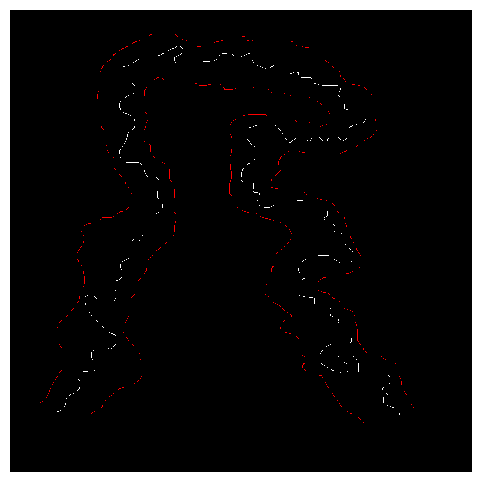

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def display_matrix_with_colors(matrix):
    
    matrix=matrix.T[::-1]
    # Create a color map: 0 -> red, 1 -> white, 2 -> white, 3 -> black
    color_map = {
        0: [0, 0, 0],      
        1: [1, 1, 1],      
        2: [1, 0, 0],      
    }

    # Create RGB image array
    height, width = matrix.shape
    rgb_image = np.zeros((height, width, 3))

    for value, color in color_map.items():
        mask = (matrix == value)
        rgb_image[mask] = color

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image, interpolation='nearest')
    plt.axis('off')
    plt.show()

display_matrix_with_colors(matrix)


In [6]:
import numpy as np

def invert_zero_one(matrix,replacer):
    matrix = np.array(matrix)
    # Create new matrix: where original is 0 -> 1, else -> 0
    new_matrix = np.where(matrix == replacer, 1, 0)
    return new_matrix

path_shape = matrix.shape

raw_path_matrix= invert_zero_one(matrix,replacer=1)
raw_boundary_matrix = invert_zero_one(matrix,replacer=2)


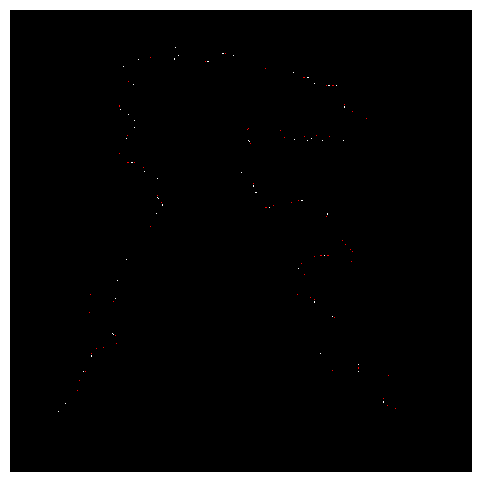

In [7]:
import numpy as np
import matplotlib.pyplot as plt


def get_control_points(constraints):

    control_points=[]

    curr_point = constraints[0]
    next_point = constraints[1]
    
    dx = (next_point[0]-curr_point[0])/2
    dy = (next_point[1]-curr_point[1])/2
    
    nx = int(round(curr_point[0]-dx))
    ny = int(round(curr_point[1]-dy))
    angle = np.arctan2(dy,dx)
    
    control_points.append((nx,ny,angle))
    
    for i in range(1,len(constraints)):
        
        curr_point=constraints[i-1]
        next_point=constraints[i]
        
        dx = (next_point[0]-curr_point[0])/2
        dy = (next_point[1]-curr_point[1])/2
        
        nx = int(round(curr_point[0]+dx))
        ny = int(round(curr_point[1]+dy))
        angle = np.arctan2(dy,dx)
        
        control_points.append((nx,ny,angle))
        
    nx = int(round(next_point[0]+dx))
    ny = int(round(next_point[1]+dy))
    angle = np.arctan2(dy,dx)
        
    control_points.append((nx,ny,angle))
    
    return control_points

def find_path_constraints(matrix, side):
    matrix = np.array(matrix)
    search_matrix = np.zeros_like(matrix, dtype=bool)
    constraint_points = []

    h, w = matrix.shape
    ef_ss = side

    # Find initial org point: 1 with only one neighboring 1
    def count_neighbors(i, j):
        count = 0
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ni, nj = i + dx, j + dy
                if 0 <= ni < h and 0 <= nj < w:
                    if matrix[ni, nj] == 1:
                        count += 1
        return count

    org = None
    for i in range(h):
        for j in range(w):
            if matrix[i, j] == 1 and count_neighbors(i, j) == 1:
                org = (i, j)
                break
        if org:
            break

    if not org:
        print("No suitable starting point found.")
        return constraint_points
    
    
    constraint_points.append(org)

    while True:
        i, j = org
        search_matrix[i, j] = True



        # Search boundary points
        found_next = False
        for dx in [-ef_ss, ef_ss]:
            for dy in range(-ef_ss, ef_ss + 1):
                ni, nj = i + dx, j + dy
                if 0 <= ni < h and 0 <= nj < w:
                    if matrix[ni, nj] == 1 and not search_matrix[ni, nj]:
                        constraint_points.append((ni, nj))
                        org = (ni, nj)
                        found_next = True
                        break
            if found_next:
                break

        if not found_next:
            for dy in [-ef_ss, ef_ss]:
                for dx in range(-ef_ss, ef_ss + 1):
                    ni, nj = i + dx, j + dy
                    if 0 <= ni < h and 0 <= nj < w:
                        if matrix[ni, nj] == 1 and not search_matrix[ni, nj]:
                            constraint_points.append((ni, nj))
                            org = (ni, nj)
                            found_next = True
                            break
                if found_next:
                    break

        if not found_next:
            break  # No more points on boundary
        
                # Mark square of side
        for dx in range(-ef_ss, ef_ss + 1):
            for dy in range(-ef_ss, ef_ss + 1):
                ni, nj = i + dx, j + dy
                if 0 <= ni < h and 0 <= nj < w:
                    search_matrix[ni, nj] = True

    # Plotting
    display_matrix = np.zeros((h, w, 3))  # RGB

    for x, y in constraint_points:
        display_matrix[x, y] = [1, 1, 1]  # white
        
    control_points = get_control_points(constraint_points)
    
    for x, y, _ in control_points:
        display_matrix[x,y] = [1, 0, 0]  # white

    display_matrix[display_matrix.sum(axis=2) == 0] = [0, 0, 0]  # black
    
    display_matrix = display_matrix.transpose(1, 0, 2)[::-1]

    plt.figure(figsize=(6, 6))
    plt.imshow(display_matrix, interpolation='nearest')
    plt.axis('off')
    plt.show()

    return constraint_points

# matrix = [
#     [0, 0, 0, 0, 0],
#     [0, 1, 1, 1, 0],
#     [0, 0, 0, 1, 0],
#     [0, 0, 0, 1, 0],
#     [0, 0, 0, 0, 0]
# ]

side = 5
path_points = find_path_constraints(raw_path_matrix, side)


# print(control_points)

In [8]:

import numpy as np
import matplotlib.pyplot as plt
import copy
import numpy as np
from tqdm import tqdm

def index_to_point(ij, min_dist=0.1):
    
    i,j = ij[0],ij[1]

    i, j = i*min_dist, j*min_dist

    return (i, j)

def replace_zeros_by_majority(matrix, side):
    new_matrix = matrix.copy()
    rows, cols = matrix.shape
    
    for i in tqdm(range(rows)):
        for j in range(cols):
            if matrix[i, j] == 0:
                counts = {}
                for k in range(side):
                    for di in [-k, k]:
                        for dj in [-k, k]:
                            ni, nj = i + di, j + dj
                            if 0 <= ni < rows and 0 <= nj < cols:
                                val = matrix[ni, nj]
                                if val != 0:
                                    counts[val] = counts.get(val, 0) + 1
                if counts:
                    # Find value with maximum occurrence
                    majority_val = max(counts, key=lambda x: counts[x])
                    new_matrix[i, j] = majority_val
    return new_matrix


def bresenham(i0, j0, i1, j1):
    points = []
    dx = abs(i1 - i0)
    dy = abs(j1 - j0)
    x, y = i0, j0
    sx = 1 if i0 < i1 else -1
    sy = 1 if j0 < j1 else -1
    if dx > dy:
        err = dx / 2.0
        while x != i1:
            points.append((x, y))
            err -= dy
            if err < 0:
                y += sy
                err += dx
            x += sx
    else:
        err = dy / 2.0
        while y != j1:
            points.append((x, y))
            err -= dx
            if err < 0:
                x += sx
                err += dy
            y += sy
    points.append((i1, j1))
    return points

def make_point_valid(i,j,shape):
    if i<0:
        i=0
    elif i>=shape[0]:
        i=shape[0]-1
        
    if j<0:
        j=0
    elif j>=shape[1]:
        j=shape[1]-1
        
    return i,j

def extend_line(i, j, angle, matrix, max_bound):
    for dist in range(1, max_bound + 1):
        ni = int(round(i + dist * np.cos(angle)))
        nj = int(round(j + dist * np.sin(angle)))
        if ni < 0 or nj < 0 or ni >= matrix.shape[0] or nj >= matrix.shape[1]:
            break
        if matrix[ni, nj] == 1:
            return ni, nj
        
    ni,nj = make_point_valid(ni,nj,matrix.shape)
    return ni, nj

def order_clockwise(points):
    cx = np.mean([p[0] for p in points])
    cy = np.mean([p[1] for p in points])
    angles = [np.arctan2(p[0]-cx, p[1]-cy) for p in points]
    return [p for _, p in sorted(zip(angles, points))]

def flood_fill(matrix, start_i, start_j, value):
    stack = [(start_i, start_j)]
    while stack:
        i, j = stack.pop()
        if (0 <= i < matrix.shape[0] and 0 <= j < matrix.shape[1] and matrix[i, j] == 0):
            matrix[i, j] = value
            stack.extend([(i+1,j), (i-1,j), (i,j+1), (i,j-1)])
            
def centroid_point(points):
    points = np.array(points)
    x_mean = points[:,0].mean()
    y_mean = points[:,1].mean()
    
    point = index_to_point((x_mean, y_mean))
    return point

def process_matrix(matrix, point_list,max_bound,fill_zero=True):
    
    central_points=[]
    
    # max_bound = min(matrix.shape)
    new_matrix = np.zeros_like(matrix, dtype=np.uint8)
    n = len(point_list)
    
    for idx in range(n - 1):
        (i1, j1, a1) = point_list[idx]
        (i2, j2, a2) = point_list[idx + 1]

        # Get extended points (both directions ± π/2)
        p1 = extend_line(i1, j1, a1 + np.pi/2, matrix, max_bound)
        p2 = extend_line(i1, j1, a1 - np.pi/2, matrix, max_bound)
        p3 = extend_line(i2, j2, a2 + np.pi/2, matrix, max_bound)
        p4 = extend_line(i2, j2, a2 - np.pi/2, matrix, max_bound)

        polygon = order_clockwise([p1, p2, p3, p4, (i1, j1), (i2, j2)])
        
        cp = centroid_point([p1, p2, p3, p4, (i1, j1), (i2, j2)])
        central_points.append(cp)
        
        # Draw polygon edges
        for i in range(len(polygon)):
            p_start = polygon[i]
            p_end = polygon[(i + 1) % len(polygon)]
            for pi, pj in bresenham(p_start[0], p_start[1], p_end[0], p_end[1]):
                if 0 <= pi < matrix.shape[0] and 0 <= pj < matrix.shape[1]:
                    if new_matrix[pi, pj]==0:
                        new_matrix[pi, pj] = idx + 1
        
        # Flood fill inside
        si, sj = (i1 + i2)//2, (j1 + j2)//2
        if new_matrix[si, sj] == 0:
            flood_fill(new_matrix, si, sj, idx + 1)
            
    if fill_zero:
        new_matrix=replace_zeros_by_majority(new_matrix, 2)
    
    plot_matrix=copy.deepcopy(new_matrix).T[::-1]
    # Plot the result
    plt.imshow(plot_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()
    
    return new_matrix,central_points





In [9]:
# ratio =len(path_points)//5
ratio = 20
path_points = path_points[::ratio]




origin_point = index_to_point(path_points[0])

print("Orgin Point:", origin_point)

control_points = get_control_points(path_points)

Orgin Point: (20.400000000000002, 26.1)


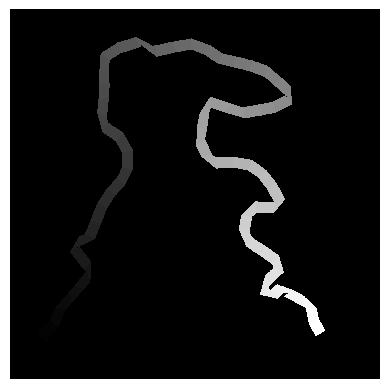

In [10]:

    
map_matrix,constraints = process_matrix(raw_boundary_matrix, control_points,max_bound=30,fill_zero=False)

# constraints=[]

# for p in path_points:
#     constraints.append(index_to_point(p))

origin = constraints[0]

# origin = control_points

In [11]:
np.save('/mnt/Personal/Projects/Micromouse/Playground/map_images/pic_data/map_matrix.npy', map_matrix)
np.save('/mnt/Personal/Projects/Micromouse/Playground/map_images/pic_data/constraints.npy', constraints)
np.save('/mnt/Personal/Projects/Micromouse/Playground/map_images/pic_data/origin.npy', origin)
